In [1]:
import pandas as pd
import re

# Load the Excel file
file_path = "/content/drive/MyDrive/AML_2025/HW_5/dermatology inclusion 2500.xlsx"
df = pd.read_excel(file_path)

# Display the first few rows and print the column names to identify the relevant columns
print("Column Names:", df.columns.tolist())
df.head()

Column Names: ['nctid', 'inclusion']


,nctid,inclusion
0,NCT00001137,HIV-1 infected * Enrolled in an AIDS Clinical ...
1,NCT00003199,Patients with inflammatory (stage IIIb) or res...
2,NCT00003895,Patients must have histologically confirmed pr...
3,NCT00004067,The patient must have a life expectancy of at ...
4,NCT00004074,Patients must have a histologically proven Her...


parse the 'inclusion' column using regular expressions to split text by delimiters like asterisks, newlines, and numbered lists.



In [2]:
def parse_inclusion(text):
    if not isinstance(text, str):
        return []
    # Split by *, newlines, or numbered lists (e.g., "1. ", "2. ")
    # Pattern explanation:
    # [\*\n\r]+ matches one or more asterisks or newlines
    # | OR
    # (?:^|\s)\d+\.\s matches a number followed by a dot and space, preceded by start of string or whitespace
    tokens = re.split(r'[\*\n\r]+|(?:^|\s)\d+\.\s', text)
    # Clean whitespace and remove empty strings
    return [t.strip() for t in tokens if t.strip()]

# Apply the parsing function
df['parsed_criteria'] = df['inclusion'].apply(parse_inclusion)

# Explode the list into individual rows
df_exploded = df.explode('parsed_criteria')

# Select relevant columns and rename for clarity
df_clean = df_exploded[['nctid', 'parsed_criteria']].rename(columns={'parsed_criteria': 'criterion'})

# Reset index and drop any potential empty rows resulted from explode (though function handles empty lists)
df_clean = df_clean.reset_index(drop=True)

# Display stats and first few rows
print(f"Original number of rows: {len(df)}")
print(f"Number of rows after exploding criteria: {len(df_clean)}")
df_clean.head(10)

Original number of rows: 3104
Number of rows after exploding criteria: 29962


,nctid,criterion
0,NCT00001137,HIV-1 infected
1,NCT00001137,Enrolled in an AIDS Clinical Trial Group (ACTG...
2,NCT00001137,Willing to provide consent for the release and...
3,NCT00001137,Life expectancy of at least 24 weeks
4,NCT00001137,Parent or guardian willing to provide informed...
5,NCT00001137,Active alcohol or drug abuse that may interfer...
6,NCT00003199,Patients with inflammatory (stage IIIb) or res...
7,NCT00003199,Patients should have received 4-7 cycles of an...
8,NCT00003199,Patient has received Cytoxan 4 gm/m\^2 x 1 and...
9,NCT00003199,Stem cells were collected after mobilization w...


CountVectorizer from sklearn and apply it to the 'criterion' column with the specified parameters (stop_words, min_df, max_df, ngram_range) to convert the text data into numerical vectors.



In [3]:
from sklearn.feature_extraction.text import CountVectorizer

# Instantiate the CountVectorizer with specified parameters
vectorizer = CountVectorizer(
    stop_words='english',
    min_df=10,
    max_df=0.95,
    ngram_range=(1, 2)
)

# Fit and transform the criterion column
X_bow = vectorizer.fit_transform(df_clean['criterion'])

# Print the shape of the resulting sparse matrix
print(f"Shape of Bag of Words Matrix: {X_bow.shape}")

# Display the first 20 feature names to verify the vocabulary
feature_names = vectorizer.get_feature_names_out()
print("First 20 features:", feature_names[:20])

Shape of Bag of Words Matrix: (29962, 6331)
First 20 features: ['000' '000 mcl' '000 mm' '000 mm3' '000 mm³' '000 ul' '000 µl' '000 μl'
 '01' '02' '10' '10 body' '10 cells' '10 days' '10 dl' '10 hemoglobin'
 '10 her2' '10 mg' '10 mm' '10 platelet']


compare K-Means vs. MiniBatchKMeans performance.


Computing inertia for Elbow method using MiniBatchKMeans...


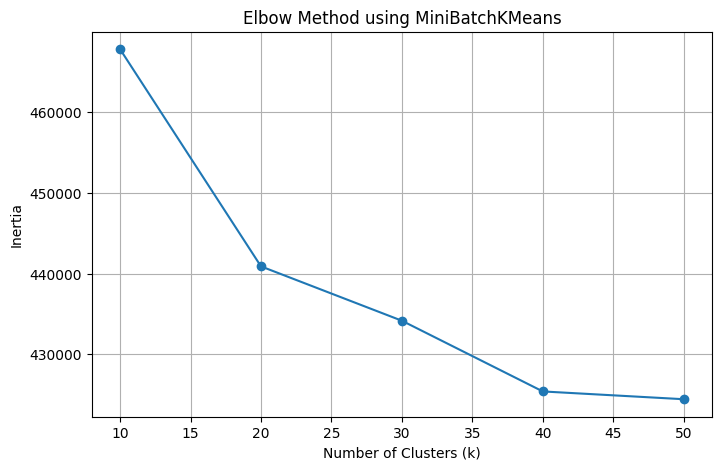


Fitting models with k=30...
Calculating Silhouette Scores (on sample of 5000)...

--- Clustering Performance Comparison ---
Model                | Inertia         | Silhouette Score    
------------------------------------------------------------
KMeans               | 424828.41       | 0.0030              
MiniBatchKMeans      | 434142.54       | -0.0841             


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import silhouette_score

# --- Step 2: Elbow Method ---
# Define range of clusters
k_range = [10, 20, 30, 40, 50]
inertias = []

print("Computing inertia for Elbow method using MiniBatchKMeans...")
for k in k_range:
    mbk = MiniBatchKMeans(n_clusters=k, random_state=42, n_init='auto')
    mbk.fit(X_bow)
    inertias.append(mbk.inertia_)

# Plot the Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertias, marker='o', linestyle='-')
plt.title('Elbow Method using MiniBatchKMeans')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()

# --- Steps 3-6: Model Comparison ---
k_optimal = 30
print(f"\nFitting models with k={k_optimal}...")

# Instantiate models
kmeans = KMeans(n_clusters=k_optimal, random_state=42, n_init='auto')
mb_kmeans = MiniBatchKMeans(n_clusters=k_optimal, random_state=42, n_init='auto')

# Fit models
kmeans.fit(X_bow)
mb_kmeans.fit(X_bow)

# Evaluation - Silhouette Score on a sample
sample_size = 5000
if X_bow.shape[0] > sample_size:
    # Use numpy to generate random indices
    indices = np.random.choice(X_bow.shape[0], size=sample_size, replace=False)
    X_sample = X_bow[indices]
    # Get labels for the sample
    labels_km_sample = kmeans.labels_[indices]
    labels_mb_sample = mb_kmeans.labels_[indices]
else:
    X_sample = X_bow
    labels_km_sample = kmeans.labels_
    labels_mb_sample = mb_kmeans.labels_

print("Calculating Silhouette Scores (on sample of 5000)...")
sil_km = silhouette_score(X_sample, labels_km_sample)
sil_mb = silhouette_score(X_sample, labels_mb_sample)

# Print Comparison
print("\n--- Clustering Performance Comparison ---")
print(f"{'Model':<20} | {'Inertia':<15} | {'Silhouette Score':<20}")
print("-" * 60)
print(f"{'KMeans':<20} | {kmeans.inertia_:<15.2f} | {sil_km:<20.4f}")
print(f"{'MiniBatchKMeans':<20} | {mb_kmeans.inertia_:<15.2f} | {sil_mb:<20.4f}")

export the results to a tab-delimited file.


In [10]:
# Assign TF-IDF cluster labels to the dataframe
df_clean['cluster'] = kmeans_tfidf.labels_

# Define output filename for TF-IDF results to distinguish from the previous one
output_file_tfidf = 'results_lastname_lastname_tfidf.txt'

# Save to tab-delimited file
df_clean[['nctid', 'criterion', 'cluster']].to_csv(output_file_tfidf, sep='\t', index=False)

# Verify result
print(df_clean[['nctid', 'criterion', 'cluster']].head())
print(f"\nTF-IDF Results file saved successfully: {output_file_tfidf}")

         nctid                                          criterion  cluster
0  NCT00001137                                     HIV-1 infected       15
1  NCT00001137  Enrolled in an AIDS Clinical Trial Group (ACTG...       15
2  NCT00001137  Willing to provide consent for the release and...       15
3  NCT00001137               Life expectancy of at least 24 weeks        2
4  NCT00001137  Parent or guardian willing to provide informed...       22

TF-IDF Results file saved successfully: results_lastname_lastname_tfidf.txt


In [6]:
# Assign cluster labels to the dataframe
df_clean['cluster'] = kmeans.labels_

# Define output filename
output_file = 'results_lastname_lastname.txt'

# Save to tab-delimited file
df_clean[['nctid', 'criterion', 'cluster']].to_csv(output_file, sep='\t', index=False)

# Verify result
print(df_clean[['nctid', 'criterion', 'cluster']].head())
print(f"\nFile saved successfully: {output_file}")

         nctid                                          criterion  cluster
0  NCT00001137                                     HIV-1 infected       20
1  NCT00001137  Enrolled in an AIDS Clinical Trial Group (ACTG...       12
2  NCT00001137  Willing to provide consent for the release and...       20
3  NCT00001137               Life expectancy of at least 24 weeks       22
4  NCT00001137  Parent or guardian willing to provide informed...       19

File saved successfully: results_lastname_lastname.txt



Transform the criteria text into a TF-IDF feature matrix using specified parameters.


In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Instantiate the TfidfVectorizer with specified parameters
tfidf_vectorizer = TfidfVectorizer(
    stop_words='english',
    min_df=10,
    max_df=0.95,
    ngram_range=(1, 2)
)

# Fit and transform the criterion column
X_tfidf = tfidf_vectorizer.fit_transform(df_clean['criterion'])

# Print the shape of the resulting sparse matrix
print(f"Shape of TF-IDF Matrix: {X_tfidf.shape}")

# Display the first 20 feature names to verify the vocabulary
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
print("First 20 features:", tfidf_feature_names[:20])

Shape of TF-IDF Matrix: (29962, 6331)
First 20 features: ['000' '000 mcl' '000 mm' '000 mm3' '000 mm³' '000 ul' '000 µl' '000 μl'
 '01' '02' '10' '10 body' '10 cells' '10 days' '10 dl' '10 hemoglobin'
 '10 her2' '10 mg' '10 mm' '10 platelet']


In [9]:
# Fit K-Means with n_clusters=30 on TF-IDF matrix
kmeans_tfidf = KMeans(n_clusters=30, random_state=42, n_init='auto')
kmeans_tfidf.fit(X_tfidf)

# Calculate Silhouette Score on a random sample of 5000
sample_size = 5000
if X_tfidf.shape[0] > sample_size:
    # Using a fixed seed for reproducibility of the sample
    rng = np.random.RandomState(42)
    indices = rng.choice(X_tfidf.shape[0], size=sample_size, replace=False)
    X_sample_tfidf = X_tfidf[indices]
    labels_sample_tfidf = kmeans_tfidf.labels_[indices]
else:
    X_sample_tfidf = X_tfidf
    labels_sample_tfidf = kmeans_tfidf.labels_

sil_tfidf = silhouette_score(X_sample_tfidf, labels_sample_tfidf)

# Display Comparison Table
print("\n--- Clustering Performance Comparison: BoW vs TF-IDF ---")
print(f"{'Model':<20} | {'Inertia':<15} | {'Silhouette Score':<20}")
print("-" * 60)
# Note: kmeans and sil_km are available from the previous BoW execution
print(f"{'BoW K-Means':<20} | {kmeans.inertia_:<15.2f} | {sil_km:<20.4f}")
print(f"{'TF-IDF K-Means':<20} | {kmeans_tfidf.inertia_:<15.2f} | {sil_tfidf:<20.4f}")

# Brief Summary
print("\n--- Summary ---")
if sil_tfidf > sil_km:
    print("TF-IDF vectorization resulted in a higher Silhouette Score, indicating better cluster separation compared to Bag of Words.")
else:
    print("TF-IDF vectorization resulted in a lower or similar Silhouette Score, indicating it did not improve cluster separation compared to Bag of Words.")


--- Clustering Performance Comparison: BoW vs TF-IDF ---
Model                | Inertia         | Silhouette Score    
------------------------------------------------------------
BoW K-Means          | 424828.41       | 0.0030              
TF-IDF K-Means       | 26483.91        | 0.0303              

--- Summary ---
TF-IDF vectorization resulted in a higher Silhouette Score, indicating better cluster separation compared to Bag of Words.
